In [103]:
# 1. Data Acquisition and Initial Exploration
# Load the datasets
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns  # Added for enhanced visualizations
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
import joblib

train_file_path = 'C:/Users/ELITEBOOK/GOLD_PRICE_PREDICTION/goldstock_csv/goldstock v2.csv'
test_file_path = 'C:/Users/ELITEBOOK/GOLD_PRICE_PREDICTION/goldstock_csv/goldstock v1.csv'

train_df = pd.read_csv(train_file_path)
test_df = pd.read_csv(test_file_path)

# Print initial info and description (as per assignment instructions)
print("Train Data Info:")
print(train_df.info())  # Look for data types and missing values
print("\nTrain Data Description:")
print(train_df.describe())  # Get summary statistics

print("\nTest Data Info:")
print(test_df.info())
print("\nTest Data Description:")
print(test_df.describe())

# Check for missing values *before* feature engineering (as missing values can cause errors)
print("\nMissing values before feature engineering (Train):\n", train_df.isnull().sum())
print("\nMissing values before feature engineering (Test):\\n", test_df.isnull().sum())

Train Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2511 entries, 0 to 2510
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  1129 non-null   float64
 1   Date        1129 non-null   object 
 2   Close/Last  1129 non-null   float64
 3   Volume      1129 non-null   float64
 4   Open        1129 non-null   float64
 5   High        1129 non-null   float64
 6   Low         1129 non-null   float64
dtypes: float64(6), object(1)
memory usage: 137.4+ KB
None

Train Data Description:
        Unnamed: 0   Close/Last         Volume         Open         High  \
count  1129.000000  1129.000000    1129.000000  1129.000000  1129.000000   
mean    565.913198  1878.634367  184237.699734  1878.738264  1891.717095   
std     327.369593   170.227283   88155.524454   170.081528   171.394760   
min       0.000000  1477.900000       6.000000  1469.300000  1483.500000   
25%     282.000000  1776.000000  140032.0000

In [104]:
# 2. Feature Engineering and Cleaning
# Map and transform the columns to what we want.
train_df = train_df[['Close/Last', 'Volume', 'Open', 'High', 'Low', 'Date']]
test_df = test_df[['Close', 'Volume', 'Open', 'High', 'Low', 'Date']]

# Rename columns with consistent names
train_df.rename(columns={'Close/Last': 'Close'}, inplace=True)

# Combine them, and extract time
combined_df = pd.concat([train_df, test_df], ignore_index=True)
combined_df['Date'] = pd.to_datetime(combined_df['Date'])
combined_df['year'] = combined_df['Date'].dt.year
combined_df['month'] = combined_df['Date'].dt.month
combined_df['day'] = combined_df['Date'].dt.day
combined_df['weekday'] = combined_df['Date'].dt.weekday
combined_df['is_weekend'] = combined_df['Date'].dt.weekday >= 5
combined_df = combined_df.drop("Date", axis=1) #remove the source

# Set all objects and the isweekend, to be a str because of pandas.
X = combined_df.drop('Close', axis=1)
for col in X.select_dtypes(include=['object']).columns:
    X[col] = X[col].astype(str)  # Convert to string
X['is_weekend'] = X['is_weekend'].astype(str)

print(combined_df.head())

    Close    Volume    Open    High     Low    year  month   day  weekday  \
0  2369.4  185930.0  2338.6  2374.5  2335.7  2024.0    7.0   3.0      2.0   
1  2333.4  146568.0  2341.6  2346.1  2327.4  2024.0    7.0   2.0      1.0   
2  2338.9  136861.0  2336.2  2348.8  2328.2  2024.0    7.0   1.0      0.0   
3  2339.6  131191.0  2338.6  2350.6  2329.7  2024.0    6.0  28.0      4.0   
4  2336.6  135784.0  2309.4  2342.0  2306.8  2024.0    6.0  27.0      3.0   

   is_weekend  
0       False  
1       False  
2       False  
3       False  
4       False  


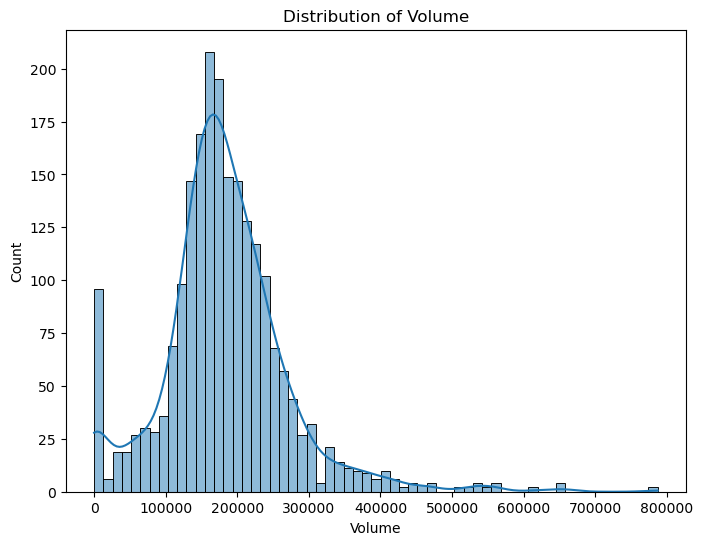

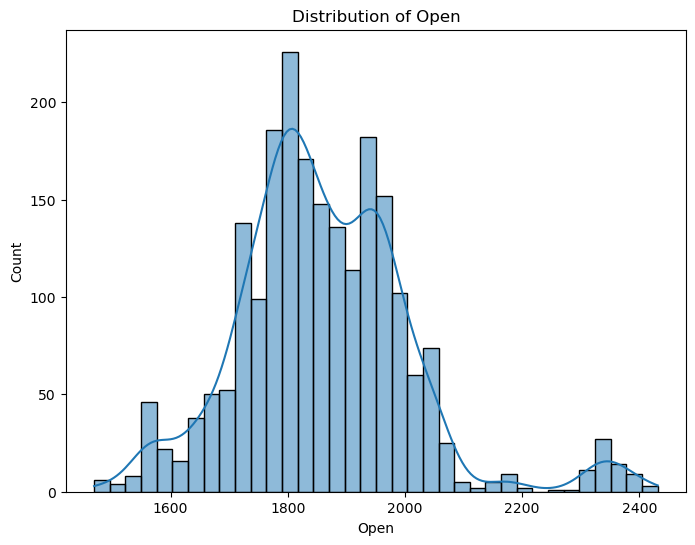

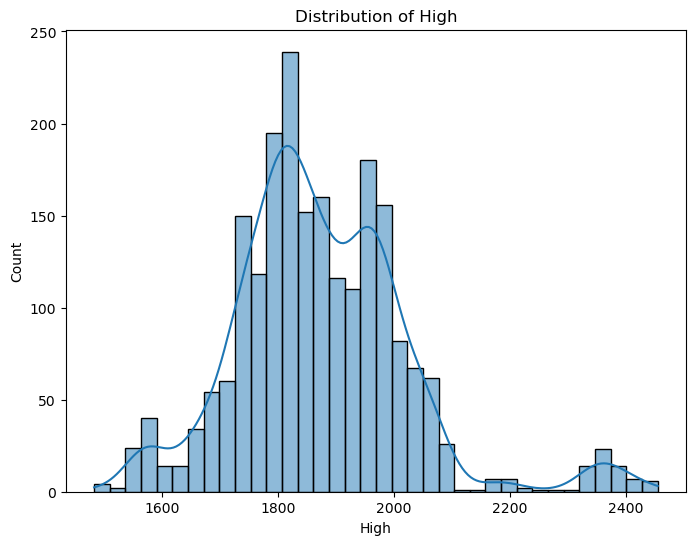

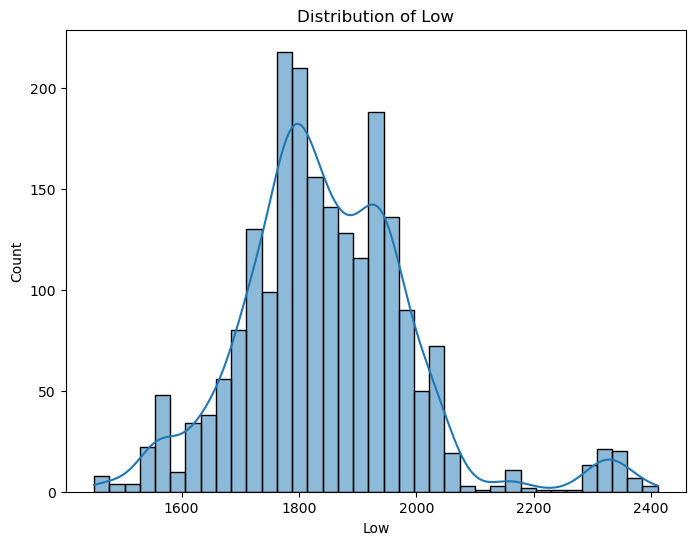

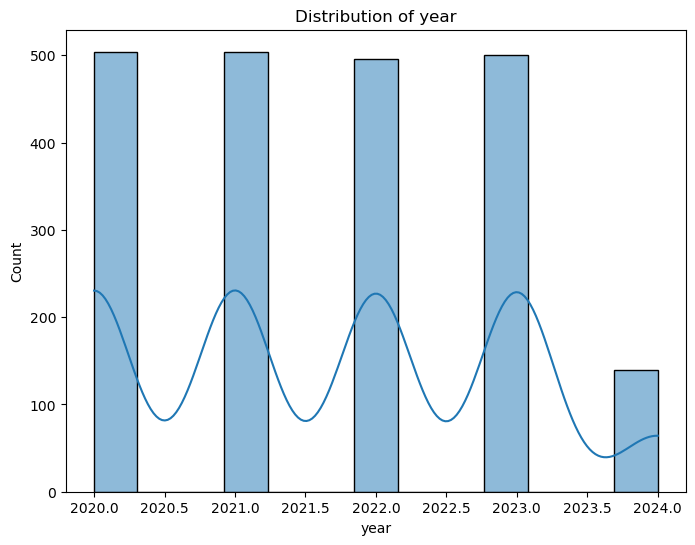

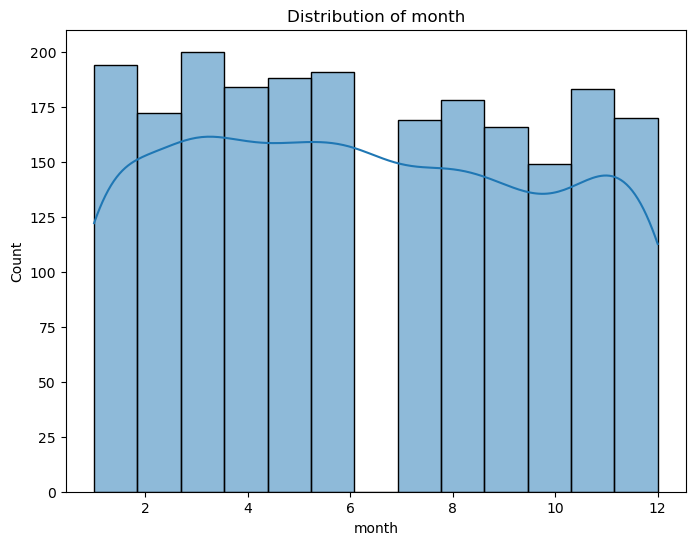

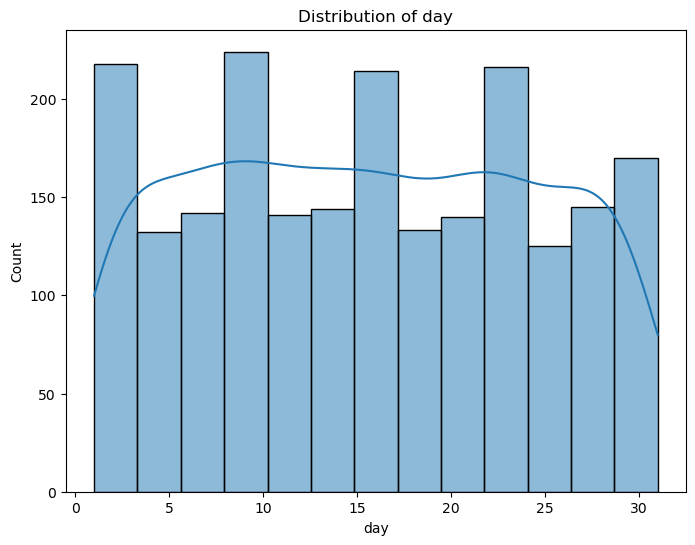

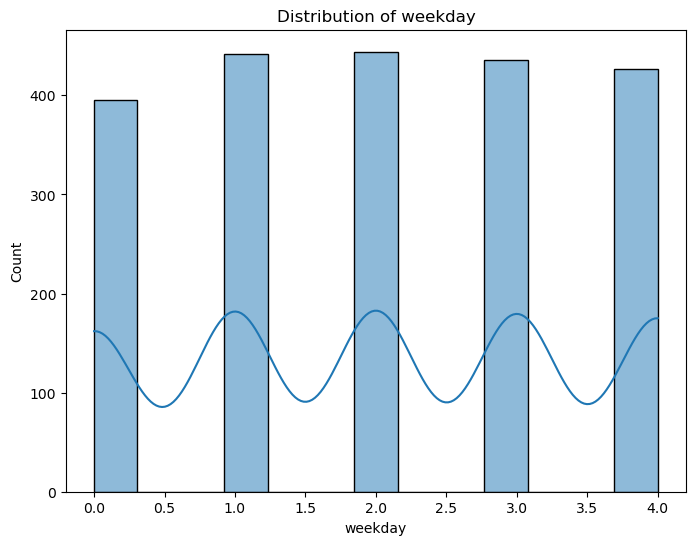

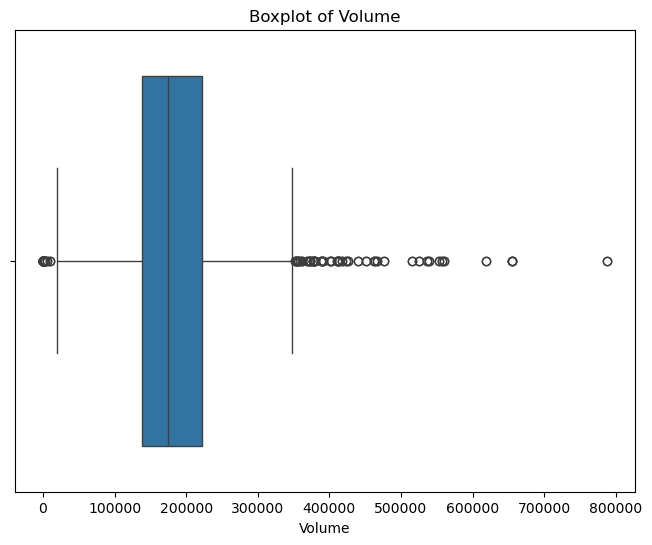

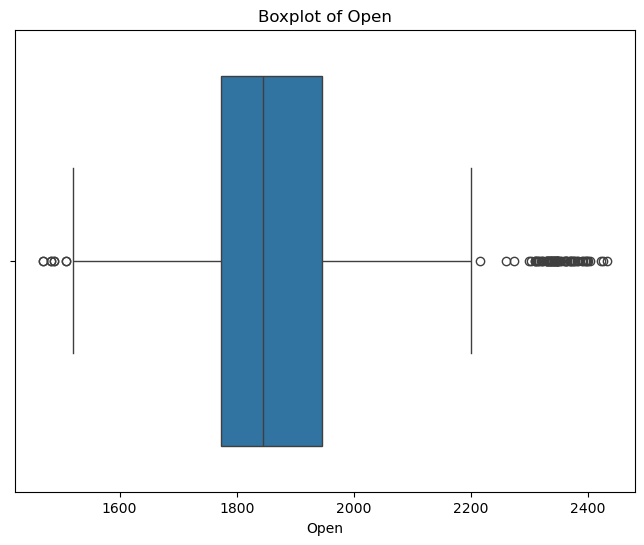

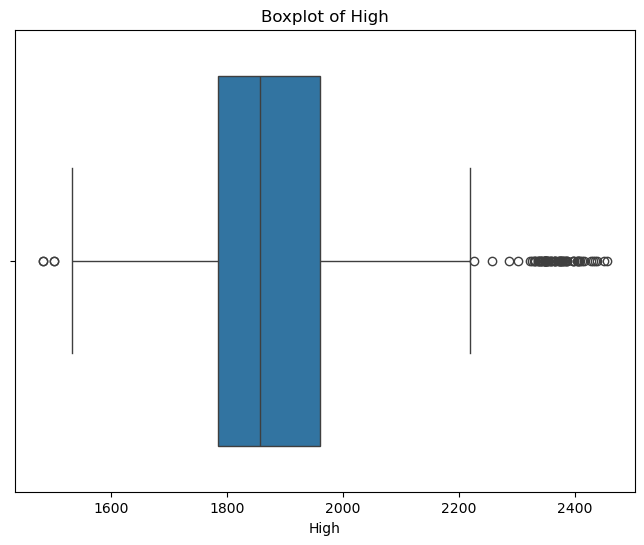

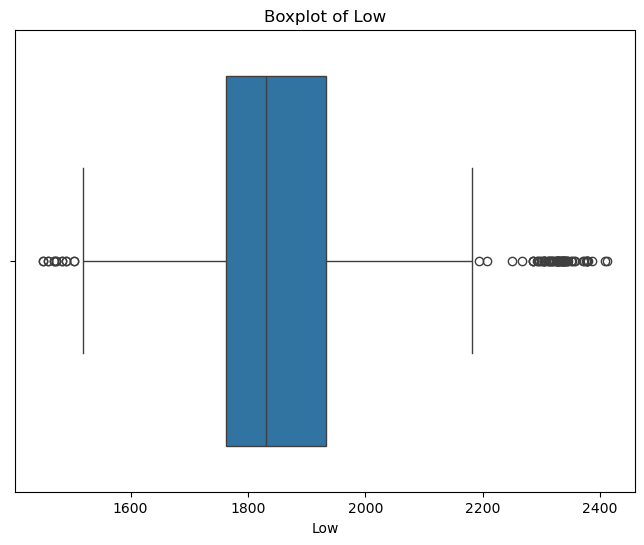

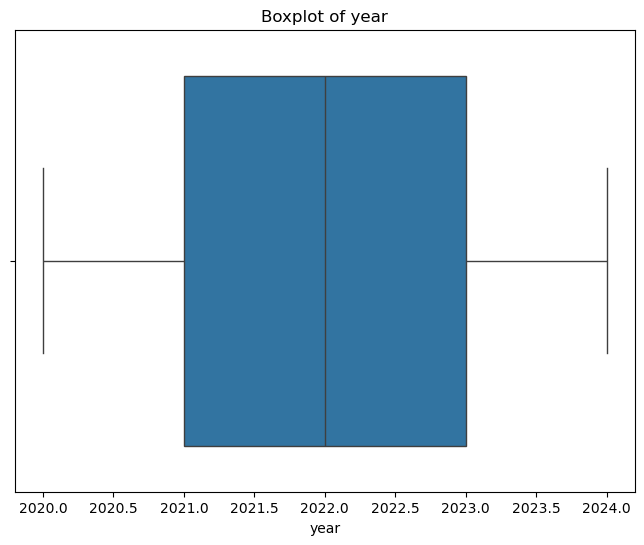

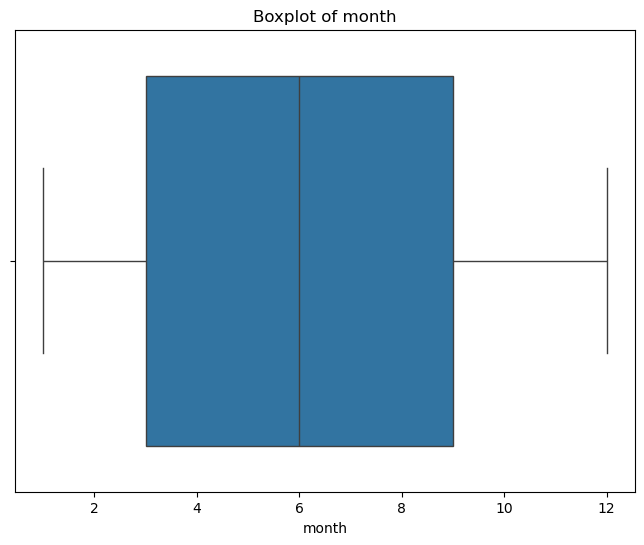

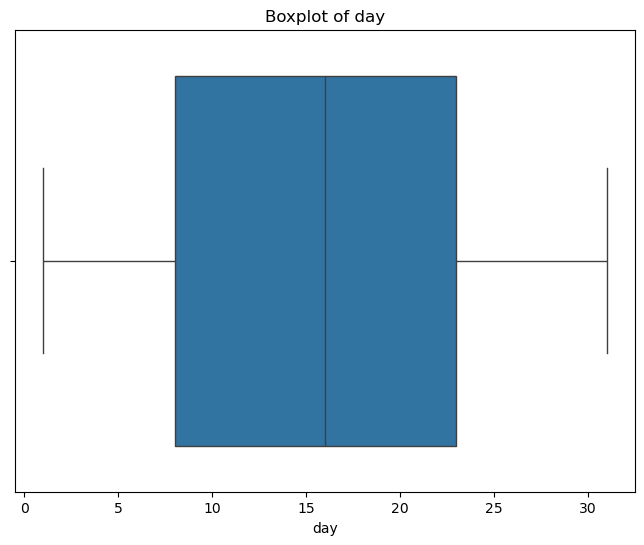

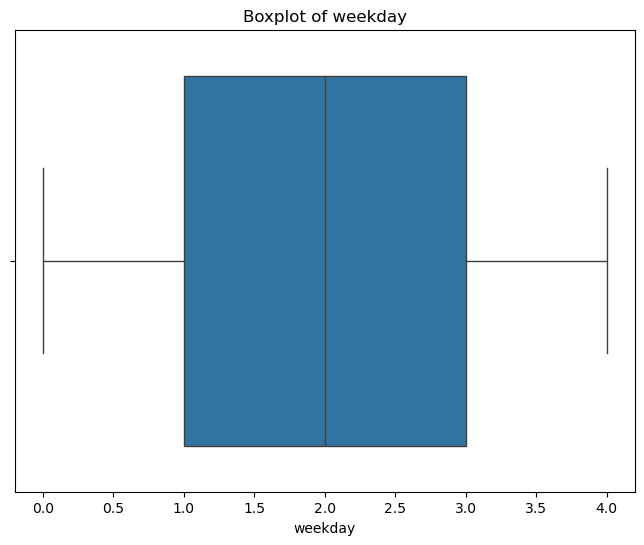

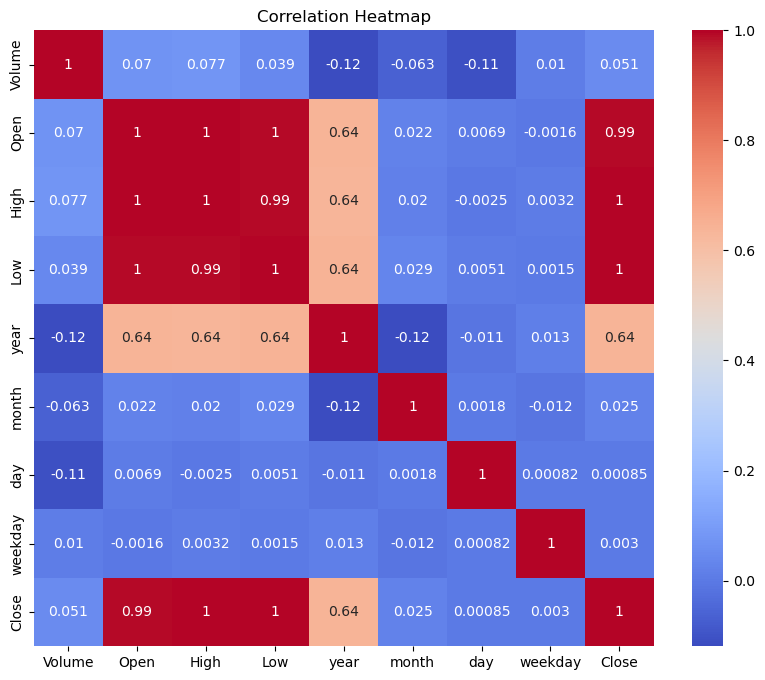

In [105]:
# 3. EDA - Data Visualization (addresses project requirements)
# Distribution plots for numerical features
numerical_cols = ['Volume', 'Open', 'High', 'Low', 'year', 'month', 'day', 'weekday']
for col in numerical_cols:
    plt.figure(figsize=(8, 6))
    sns.histplot(combined_df[col], kde=True)
    plt.title(f'Distribution of {col}')
    plt.show()

# Box plots for outlier detection (numerical features)
for col in numerical_cols:
    plt.figure(figsize=(8, 6))
    sns.boxplot(x=combined_df[col])
    plt.title(f'Boxplot of {col}')
    plt.show()

# Correlation heatmap (Numerical features)
plt.figure(figsize=(10, 8))
sns.heatmap(combined_df[numerical_cols + ['Close']].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

In [106]:
# 4. Prepare data - Remove the NaNs and everything
combined_df = combined_df.dropna(subset=['Close'])

In [107]:
# 5. Baseline model (added for comparison purposes)
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_absolute_error, r2_score  # Import the metric functions

dummy_regr = DummyRegressor(strategy="mean")
X = combined_df.drop('Close', axis=1)
y = combined_df['Close']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

dummy_regr.fit(X_train, y_train)
y_pred_dummy = dummy_regr.predict(X_test)
mae_dummy = mean_absolute_error(y_test, y_pred_dummy)
r2_dummy = r2_score(y_test, y_pred_dummy)

print(f"Dummy Regressor MAE: {mae_dummy}")
print(f"Dummy Regressor R2: {r2_dummy}")

Dummy Regressor MAE: 109.50520663010458
Dummy Regressor R2: -4.7237816988676684e-05


In [108]:
# 6. Data preparation before Model Fitting
X = combined_df.drop('Close', axis=1)
y = combined_df['Close']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Add Column names to X_train and X_test
X_train.columns = ['Volume', 'Open', 'High', 'Low', 'year', 'month', 'day', 'weekday', 'is_weekend']
X_test.columns = ['Volume', 'Open', 'High', 'Low', 'year', 'month', 'day', 'weekday', 'is_weekend']

# Fit the scaler (very important!)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [109]:
#7. Inspect Data types and shape
print(f"Shape of X_train {X_train.shape}")
print(f"Shape of X_test {X_test.shape}")
print(f"datatypes for X_train and y_train {X_train.dtype} and {y_train.dtype}")

Shape of X_train (1715, 9)
Shape of X_test (429, 9)
datatypes for X_train and y_train float64 and float64


In [110]:
# 8. Train and Optimize the Model
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [4, 6, 8, 10],
    'min_samples_split': [2, 4],
    'min_samples_leaf': [1, 2]
}

grid_search = GridSearchCV(estimator=RandomForestRegressor(random_state=42),
                           param_grid=param_grid,
                           scoring='neg_mean_absolute_error', # Scoring by MAE
                           cv=3, #3-fold cross validation
                           n_jobs=-1)

grid_search.fit(X_train, y_train)

# Get best estimator
best_model = grid_search.best_estimator_
print("Best hyperparameters:", grid_search.best_params_)

Best hyperparameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}


In [111]:
# 9. Evaluate the Model
from sklearn.metrics import mean_absolute_error, r2_score

y_pred = best_model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred) # Revert back to what you want

print(f"Mean absolute error {mae}")
print(f"R2 is this {r2}")

Mean absolute error 4.263112228641647
R2 is this 0.9982618231241299


In [112]:
# Persist Model and Feature Names
joblib.dump(best_model, "model.pkl")
joblib.dump({'scaler': scaler}, 'preprocessor.pkl')
joblib.dump(list(X.columns), 'features.pkl') #Saving here

['features.pkl']